In [120]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
import pandas as pd
import numpy as np

file_path = '/content/drive/My Drive/SSL/embedded.csv'

In [122]:
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,review,topic,embedding
0,0,수업 운영이 주먹구구식입니다.,교수님 강의스타일 및 강의력,[-7.87042439e-01 7.31145322e-01 1.95688337e-...
1,1,중요 과제 공지도 사흘 전에 기말 과제가 계획에 있다가도 사라지고 강의도 머신러닝 ...,로드,[-3.72840673e-01 2.14865059e-01 -3.87998261e-...
2,2,본인이 따로 알아보고 찾아봐야 이해에 도움이 될 겁니다.,로드,[ 1.97239473e-01 -7.09244251e-01 -1.92977898e-...
3,3,다만 교수님은 좋으십니다.,교수님 강의스타일 및 강의력,[-6.28514886e-01 4.23117168e-02 -7.64399171e-...
4,4,"무난합니딘, 성적도 잘 주는 것 같아요.",학점,[-2.25575939e-01 -8.20995346e-02 -3.75468403e-...


In [123]:
# string list -> float list
def convert_string_to_list(array_str : str) -> list[float]:
    array_str = array_str.replace("[", "")
    array_str = array_str.replace("]", "")
    array_str = array_str.replace("\n", "")
    array_str = array_str.split(" ")
    array_str = list(filter(lambda x: x != '', array_str))
    return list(map(float, array_str))

In [124]:
# embedding column의 모든 열에 convert_string_to_list을 적용
df['embedding'] = df.apply(lambda row: convert_string_to_list(row['embedding']), axis=1 )

In [125]:
print(type(df['embedding'][100]))

<class 'list'>


In [126]:
df_copy = df.copy()

In [127]:
lengths = df_copy["embedding"].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [128]:
print(type(lengths))

<class 'pandas.core.series.Series'>


In [131]:
type(df["embedding"][0][0])

float

In [132]:
for i in range(len(lengths)):
    if lengths[i] != 768:
        print(i)

In [133]:
# 길이가 768이 아닌 인덱스 리스트
#indices_to_drop = [263, 396, 408, 601, 821, 841, 898, 918]

# 해당 인덱스의 행을 삭제
#df = df.drop(indices_to_drop)


In [134]:
from sklearn.preprocessing import LabelEncoder

# 토픽(라벨) 인코딩
label_encoder = LabelEncoder()
df['encoded_topic'] = label_encoder.fit_transform(df['topic'])

In [135]:
from sklearn.model_selection import train_test_split

In [136]:
df = df[df["topic"].notnull()]
null_count = df["topic"].isnull().sum()
print(null_count)

0


In [137]:
# train/val/test dataset split
# 1) train 0.7 temporary 0.3으로 데이터 분할
df = df[df["topic"].isin(["로드", "수업 내용", "시험 출제 스타일", "해당 사항 없음", "학점", "교수님 강의스타일 및 강의력"])]
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['topic'])

# 2) temp를 다시 val 0.15 test 0.15로 데이터 분할
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['topic'])

In [138]:
X_train = np.array(train_df['embedding'].tolist())  # 임베딩 데이터
X_val = np.array(val_df['embedding'].tolist())
X_test = np.array(test_df['embedding'].tolist())

y_train = label_encoder.fit_transform(train_df['topic'])
y_val = label_encoder.transform(val_df['topic'])
y_test = label_encoder.transform(test_df['topic'])

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Embedding, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization

In [143]:
# GRU 모델 생성 함수 정의
def create_gru_model(input_shape, num_classes):
    model = Sequential()

    # 첫 번째 GRU 레이어; RNN에서는 tanh 많이 쓰임, dropout은 과적합 방지,
    model.add(GRU(units=64, return_sequences=True, input_shape=input_shape, activation='tanh', dropout=0.2, recurrent_dropout=0.2))

    # 두 번째 GRU 레이어; 과적합 방지하기 위해 첫 번째 레이어보다 더 적은 수의 유닛 사
    model.add(GRU(units=32, activation='tanh', dropout=0.2, recurrent_dropout=0.2))

    # 출력 레이어
    model.add(Dense(units=num_classes, activation='softmax'))  # 다중 클래스 분류를 위한 softmax 사용

    # 모델 컴파일
    optimizer = Adam(learning_rate=0.0001)  # clipnorm을 설정
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [144]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # (샘플 수, 타임스텝 수, 특성 수)

In [145]:
# 입력 형태와 클래스 수 설정
input_shape = (X_train.shape[1], 1)  # (타임스텝 수, 특성 수)
num_classes = 6  # 0부터 4까지의 카테고리(클래스)

# 모델 생성
gru_model = create_gru_model(input_shape, num_classes)

In [ ]:
gru_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.2130 - loss: 1.7870 - val_accuracy: 0.1940 - val_loss: 1.7784
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.2541 - loss: 1.7648 - val_accuracy: 0.2198 - val_loss: 1.7637
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.2334 - loss: 1.7491 - val_accuracy: 0.2557 - val_loss: 1.7520
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.2463 - loss: 1.7370 - val_accuracy: 0.2773 - val_loss: 1.7500
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.2482 - loss: 1.7277 - val_accuracy: 0.2759 - val_loss: 1.7471
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.2611 - loss: 1.7323 - val_accuracy: 0.2629 - val_loss: 1.7480
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.2526 - loss: 1.7301 - val_accuracy: 0.2629 - val_loss: 1.7476
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.2768 - loss: 1.7211 - val_accuracy: 0.2701 - v

In [ ]:
# 예측
GRU_prediction = gru_model.predict(X_test)

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [ ]:
# 예측 결과 확인
GRU_prediction_classes = np.argmax(GRU_prediction, axis=1) # 5개의 토픽들 중 속할 확률이 가장 높은 토픽 카테고리 반
print(GRU_prediction_classes[1:10])  # 예측 클래스 출력

[0 0 0 0 0 0 0 0 0]


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def actual_pred_plot(predictions, actual_labels):
    plt.figure(figsize=(12, 6))

    # 예측 클래스와 실제 클래스 비교
    plt.plot(predictions, label='Predicted Classes', marker='o', color='blue')
    plt.plot(actual_labels, label='Actual Classes', marker='x', color='red')

    plt.title('GRU Model Predictions vs Actual Labels')
    plt.xlabel('Sample Index')
    plt.ylabel('Class')
    plt.xticks(np.arange(0, len(predictions), step=10))  # x축 눈금 간격 조정
    plt.yticks(np.arange(0, num_classes, step=1))  # y축 눈금 간격 조정
    plt.legend()
    plt.grid(True)
    plt.show()

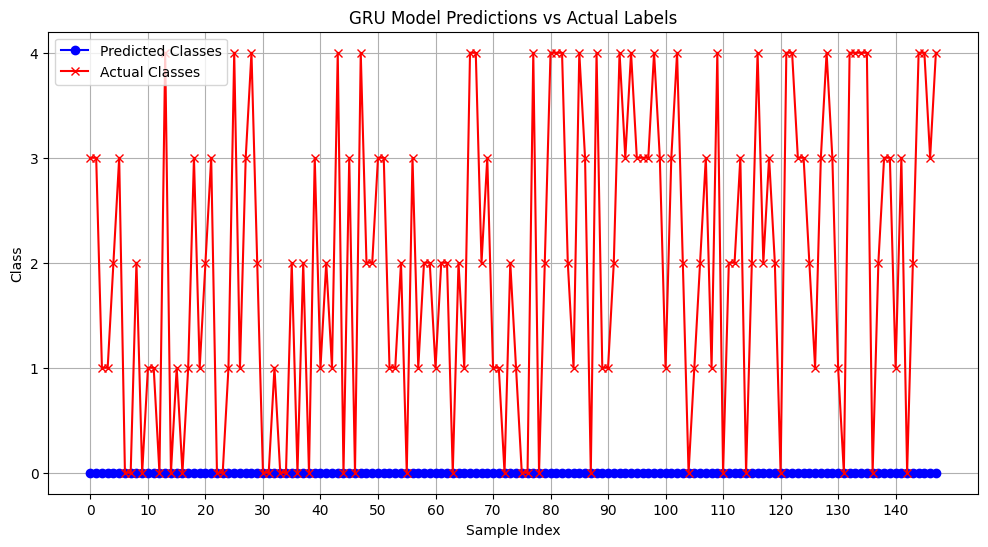

In [ ]:
# 실제 레이블 (예: y_test)와 예측 결과를 시각화
actual_pred_plot(GRU_prediction_classes, y_test)

In [ ]:
# 성능 지표 계산 및 출
from sklearn.metrics import mean_squared_error, r2_score

# GRU 예측 결과와 실제 값 DataFrame 생성
y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
y_test_gru = all_data.loc['2019':, 'Adj Close'][0:len(GRU_prediction)]
y_test_gru.reset_index(drop=True, inplace=True)

# 성능 지표 계산 함수 정의
def confirm_result(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

# 성능 지표 출력
confirm_result(y_test_gru, y_pred_gru)

#여기서부터 계속 파라미터 고치고 학습시키고 고치고 학습. 시간이 많이 없어서 몇 번 못 해볼 듯

In [ ]:
import json

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# embedding file 불러오기
json_file_path = '/content/drive/MyDrive/SSL/embedding.json/embedding.json'

# 분할할 크기 설정
chunk_size = 1000

# 분할된 파일을 저장할 카운터
counter = 0
current_chunk = []

In [ ]:
# JSON 파일을 읽고 분할
with open(json_file_path, 'r') as f:
    data = json.load(f)  # 전체 JSON을 메모리에 올림

    for i in range(0, len(data), chunk_size):
        chunk = data[i:i + chunk_size]
        with open(f'/content/drive/MyDrive/SSL/embedding_part_{counter}.json', 'w') as f_out:
            json.dump(chunk, f_out, ensure_ascii=False, indent=4)
        counter += 1

In [ ]:
# JSON 파일 읽기. 일단 가져왔다고 치자...
with open(json_file_path, 'r', encoding='utf-8') as f:
    new_data = json.load(f)

In [ ]:
# 일단 임베딩 추출
new_embeddings = np.array([entry['embedding'] for entry in new_data])

In [ ]:
# 예측 수행
predictions = gru_model.predict(new_embeddings)

# 예측 결과 처리
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
# 각 클래스에 대한 확률 분포 시각화 -> 이거 보고 레이블 데이터로 머지할 데이터 선정하기 위한 threshold 정하기
for i in range(num_classes):
    plt.hist(predictions[:, i], bins=50, alpha=0.5, label=f'Class {i}')
plt.title('Predicted Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
#threshold = 0.7 /위에서 분포 보고 결정
#predicted_classes = np.argmax(predictions, axis=1)
#confident_predictions = predicted_classes[np.max(predictions, axis=1) >= threshold]

In [ ]:
#이런 식으로 머지해서 계속 재학습. 이걸 몇 번 반복할 수 있을 지는 모르겠음. 일단 내 노트북으로는 로컬에서 embedding.json 파일이 안 열려 ,,,

# 기존 라벨링된 데이터와 신뢰도가 높은 예측 결과 병합
X_combined = np.concatenate((X_train, new_embeddings[confident_indices]), axis=0)
y_combined = np.concatenate((y_train, confident_predictions), axis=0)

# 모델 재학습
gru_model.fit(X_combined, y_combined, epochs=50, batch_size=32, verbose=1, validation_split=0.2)